# Sampling the Imaginary

Dalam pengenalan bayesian, sering digunakan kasus medis untuk mengenalkan kesimpulan posterior. Semisal ada penyakit vampirisme. Penyakit ini dapat diuji dengan suatu metode yang dapat mendeteksi keberadaan penyakit dengan akurasi $95%$. Dalam notasi matematik dapat ditulis dengan $\text{Pr}(\;+\;|\;\text{terinfeksi}\;)=0.95$. Sayangnya, metode ini memiliki kemungkinan salah kesimpulan, menduga bahwa orang yang tidak terinfeksi, positif. Kemungkinan ini kecil, hanya $1%$ saja. Dalam notasi matematik dapat ditulis dengan $\text{Pr}(\;+\;|\;\text{tidak terinfeksi}\;)=0.01$. Informasi selanjutnya adalah jumlah orang yang terinfeksi hanya sedikit, yaitu $0.001%$ dari total populasi.
> Apabila suatu pengujian berkesimpulan positif, maka seberapa mungkin subjek test adalah benar-terinfeksi?

Menggunakan bayesian, kasus diatas dapat ditulis
$$\text{Pr}(\;\text{terinfeksi}\;|\;+\;) = \frac{\text{Pr}(\;+\;|\;\text{terinfeksi}\;) \times \text{Pr}(\;\text{terinfeksi}\;)}{\text{Pr}(\;\text{+}\;)}$$

$$
\text{Pr}(\;\text{+}\;) = \text{Pr}(\;+\;|\;\text{terinfeksi}\;) \text{Pr}(\;\text{terinfeksi}\;) + \text{Pr}(\;+\;|\;\text{tidak terinfeksi}\;) (1- \text{Pr}(\;\text{terinfeksi}\;))
$$

In [5]:
pos_infected = 0.95
infected = 0.001
pos_notinfected = 0.01
notinfected = 0.999
pos = (pos_infected * infected) + (pos_notinfected * notinfected)

infected_pos = (pos_infected * 0.001) / pos
print("Infected and Positive {}".format(infected_pos))

Infected and Positive 0.08683729433272395


Apabila pendekatan perhitungan maka dapat dituliskan sebagai   
1) Ada 100.000 penduduk, 100 diantaranya terinfeksi   
2) Apabila semua penduduk diuji, maka akan ada 999 didapati terinfeksi meski tidak dan 95 yang benar benar terinfeksi   
3) Jumlah tes positive adalah $999 + 95 = 1094$   

Maka dari itu jumlah yang terinfeksi dan hasilnya positif adalah $\frac{95}{1094}=0.086\ldots$. Hasil ini sama dengan pendekatan sebelumnya.

Dalam bab ini, diajari cara berkerja dengan sampel dari distribusi posterior. Diajari juga bagaimana menyimpulkan posterior dan hasil model. Bab ini masih menggunakan sampel dari bab sebelumnya.

In [67]:
import numpy as np
from scipy.stats import binom, norm, beta
import seaborn as sns

from scipy.special import comb
import matplotlib.pyplot as plt

class globe_toss:
    def __init__(self):
        self.toss_history = []
        self.probability_land = 0.5
        self.probability_water = 0.5
        self.prior_function = None
        
    def toss(self, number_toss):
        result = np.random.choice(["W", "L"], number_toss, p=[self.probability_water, self.probability_land])
        toss_history = np.append(self.toss_history, result)
        self.toss_history = toss_history
        return toss_history
    
    def update_possibility_water(self, new_probability):
        self.probability_water = new_probability
        self.probability_land = 1  - new_probability
        return
    
    def reset_history(self):
        self.toss_history = []
        return
    
    def get_water_total(self):
        return np.count_nonzero(self.toss_history == "W")
    
    def get_land_total(self):
        return np.count_nonzero(self.toss_history == "L")
    
    def get_binom_toss(self):
        k = self.get_water_total()
        n = len(self.toss_history)
        p = self.probability_water
        return binom.pmf(k, n, p)
    
    def get_binom_grid(self, x_grid):
        k = self.get_water_total()
        n = len(self.toss_history)
        return [binom.pmf(k, n, p) for p in x_grid]
    
    def analytical_solution(self, n_grid=100):
        a = self.get_water_total()
        b = self.get_land_total()
        return [beta.pdf(i, a + 1, b + 1) for i in np.linspace(0,1,n_grid)]
    
    def grid_calculate_posterior(self, n_grid=100):
        x_grid = np.linspace(0, 1, n_grid + 1)
        if self.prior_function is None:
            y_prior = np.ones(n_grid + 1)
        else:
            y_prior = np.array([self.prior_function(i) for i in x_grid])
        likelihood = self.get_binom_grid(x_grid)
        posterior = np.multiply(y_prior, likelihood) / np.sum(np.multiply(y_prior, likelihood))
        return x_grid, posterior
    
    def normalize_array(self, array):
        array = np.array(array)
        arr_max = np.max(array)
        arr_min = np.min(array)
        interval = arr_max - arr_min
        
        result = (array - arr_min) / interval
        return result
    
    def register_prior_function(self, prior_function):
        self.prior_function = prior_function
    
    def __check_attribute_existance(self, check_attr):
        attr_list = list(self.__dict__.keys())
        if check_attr not in attr_list:
            return False
        else:
            return True
        
    def __interpolate_point(self, x_grid, y_grid, x_point):
        if len(x_grid) != len(y_grid):
            raise Exception("X size {} and Y size {} should be the same", len(x_grid), len(y_grid))
        end_limit = 0
        start_limit = 0
        for num, i in enumerate(x_grid):
            if i >= x_point:
                y_diff = y_grid[num] - y_grid[num-1]
                x_diff = x_grid[num] - x_grid[num-1]
                gradient = y_diff/x_diff
                return (gradient * (x_point-x_grid[num-1])) + y_grid[num-1]
        raise Exception("Error while interpolating")
        
    def __within_interval(self, value, low_limit, up_limit):
        if value < low_limit:
            return False
        if value > up_limit:
            return False
        return True

    def get_posterior_sample(self, sample_size):
        x_grid, posterior_grid = self.grid_calculate_posterior()
        return np.random.choice(x_grid, size=sample_size, p=posterior_grid/sum(posterior_grid))
    
    def get_sum_of_probability_interval(self, sample_size, bitwise_filter):
        posterior_sample = get_posterior_sample(sample_size)
        return posterior_sample[bitwise_filter(posterior_sample)]        
    
    def get_hdpi(self, interval, sample_size=None):
        if interval > 1 or interval < 0:
            raise Exception("Interval should have value from 0 to 1")
        if sample_size is None:
            sample_size = 10000
        
        increment = 1001
        analytical_solution = self.analytical_solution(1000)
        start_interval = np.linspace(0, 1 - interval, increment)
        end_interval = np.linspace(interval, 1, increment)
        zipped = list(zip(start_interval, end_interval))
        
        samples = self.get_posterior_sample(sample_size)
        current_quantile_distance = 1
        quantile_low_picked = 0
        quantile_high_picked = 0
        for start, end in zipped:
            quantile_low = np.quantile(samples, start)
            quantile_high = np.quantile(samples, end)
            if (quantile_high - quantile_low) < current_quantile_distance:
                current_quantile_distance = quantile_high - quantile_low
                quantile_low_picked = quantile_low
                quantile_high_picked = quantile_high
        
        return quantile_low_picked, quantile_high_picked

    def get_interval_balanced(self, interval):
        if interval > 1 or interval < 0:
            raise Exeption("Interval should have value from 0 to 1")
        error_limit = 0.01
        diff = 0.5 - (interval / 2)
        increment = 1001
        analytical_solution = self.analytical_solution(1000)
        start_interval = np.linspace(0, 1 - interval, increment)
        end_interval = np.linspace(interval, 1, increment)
        zipped = list(zip(start_interval, end_interval))
        
        samples = self.get_posterior_sample(10000)
        current_quantile_distance = 1
        quantile_low_picked = 0
        quantile_high_picked = 0
        for start, end in zipped:
            quantile_low = np.quantile(samples, start)
            quantile_high = np.quantile(samples, end)
            low_filter = self.__within_interval(quantile_low, diff + error_limit, diff - error_limit)
            high_filter = self.__within_interval(quantile_high,  1 - (diff - error_limit), 1 - (diff + error_limit))
            if low_filter and high_filter:
                return quantile_low, quantile_high
        raise Exception("Not found any interval that has same below and above interval")
    
    def get_maximum_posteriori(self):
        posterior = self.normalize_array(np.array(self.analytical_solution(100)))
        return np.max(posterior)
    
    def get_mean(self):
        samples = self.get_posterior_sample(10000)
        return np.average(samples)
    
    def get_median(self):
        samples = self.get_posterior_sample(10000)
        return np.quantile(samples, .5)
    
    def get_loss_function(self):
        x_grid, posterior = toss2.grid_calculate_posterior(200)
        loss_grid = []
        new_x_grid = np.linspace(0,1, 101)
        for i in new_x_grid:
            loss = np.sum(posterior * np.abs(i-x_grid))
            loss_grid.append(loss)
        return new_x_grid, loss_grid
    
    def get_binomial_sampling(self, toss_time, sample_size, proportion_water=None):
        if proportion_water is None:
            proportion_water = self.probability_water
        samples = np.random.binomial(toss_time, proportion_water, size=sample_size)
        normalized_samples = []
        for i in range(toss_time):
            normalized_sample = samples[samples==i]
            normalized_samples.append(normalized_sample)
        return np.arange(toss_time), normalized_samples
    
    def get_count_binomial_sampling(self, toss_time, sample_size, proportion_water=None):
        x_grid, samples = self.get_binomial_sampling(toss_time, sample_size, proportion_water)
        sample_count = [len(samples[i]) for i in range(len(x_grid))]
        return x_grid, sample_count
    
    def get_posterior_predictive_distribution(self, toss_times, sample_size):
        x_grid, posterior_grid = self.grid_calculate_posterior(100)
        increment = np.linspace(0, 1, 101)
        container = np.zeros(toss_times)
        for i in increment:
            new_x_grid, sampling_count = self.get_count_binomial_sampling(toss_times, sample_size, i)
            weight = self.__interpolate_point(x_grid, posterior_grid, i)
            container += np.multiply(sampling_count, weight)
        return np.arange(0, toss_times), container

    def get_binomial_sampling_random(self, toss_time, sample_size, proportion_water):
        if proportion_water is None:
            proportion_water = self.probability_water
        return np.random.binomial(toss_time, proportion_water, size=sample_size)
    
    def install_prior_function(self, new_prior_function):
        self.prior_function = new_prior_function
        
    def clear_prior_function(self):
        self.prior_function = None
            
    '''
    ================
    PLOTTING SECTION
    ================
    '''
        
    def init_plot(self, title="Posterior Distribution", **kwargs):
        f, ax = plt.subplots()
        
        try:
            width, height = kwargs['dimension']
            f.set_figwidth(width)
            f.set_figheight(height)
        except KeyError:
            f.set_figwidth(14)
            f.set_figheight(8)
        ax.title.set_text(title)
        self.ax = ax
        self.f = f
    
    '''
        Plotting for 3.2 Sampling to Summarize, Page 53
    '''
    def plot_density_posterior_sample(self, size):
        posterior_sample = self.get_posterior_sample(size)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_figwidth(14)
        fig.set_figheight(8)
        ax1.title.set_text("Posterior Sample")
        ax1.scatter(np.arange(len(posterior_sample)), posterior_sample, alpha=0.2)
        ax1.set_xlabel("Number of Samples")
        ax1.set_ylabel("Proportion of Water")
        
        ax2 = sns.distplot(posterior_sample)
        ax2.title.set_text("Posterior Distritbution from Sample")
        ax2.set_xlabel("Proportion of Water")
        ax2.set_ylabel("Density")
        
    def plot_grid_approx(self, **kwargs):
        discretization = 101
        if not self.__check_attribute_existance('ax'):
            self.init_plot()
        approx = None
        try:
            approx = kwargs['approx']
            x_grid, posterior = self.grid_calculate_posterior(approx)
            self.ax.plot(x_grid, posterior, label='{} Approx Normalized'.format(approx))
            discretization = approx + 1
        except KeyError:
            for i in [5,10,25,100]:
                x_grid, posterior = self.grid_calculate_posterior(i)
                self.ax.plot(x_grid, posterior, label='{} Approx Normalized'.format(i))
            
            x_grid = np.linspace(0,1,discretization)
            self.ax.plot(
                x_grid, 
                self.normalize_array(np.array(self.analytical_solution(discretization))), 
                label='Analytical Normalized'
            )
        try:
            if approx is not None:
                y_grid = posterior
            else:
                y_grid = self.normalize_array(np.array(self.analytical_solution(discretization)))
            interval = kwargs['interval']
            x_grid_mask = np.bitwise_and(x_grid >= interval[0], x_grid <= interval[1])
            self.ax.fill_between(x_grid, y_grid, where= x_grid_mask, alpha=0.2)            
        except KeyError:
            pass
        
        try:
            xlim = kwargs['xlim']
            self.ax.set(xlim=xlim)
        except KeyError:
            pass

        try:
            ylim = kwargs['ylim']
            self.ax.set(ylim=ylim)
        except KeyError:
            pass
        
        plt.legend()
        plt.grid()
    
    def plot_loss_function(self):
        self.init_plot("Loss Function")
        new_x_grid, loss_grid = self.get_loss_function()
        self.ax.plot(new_x_grid, loss_grid)
        plt.grid()
        return
     
    def plot_binom_sampling(self, toss_times, sample_size):
        self.init_plot("Binomial Sampling")
        x_grid, sampling = self.get_binomial_sampling(toss_times, sample_size)
        self.ax.hist(sampling, range=[0,9], facecolor='black', align='mid')
        plt.xlim(-.1, 10)
        plt.grid()
        return
    
    # Based on page 66
    def plot_multiple_binom_sampling(self, toss_times, sample_size):
        subplots_properties = {
            "nrows": 10,
            "ncols": 1,
            "figsize": (16,25),
            "sharex": True,
            "sharey": True
        }
        fig, axes = plt.subplots(**subplots_properties)

        for num, i in enumerate(axes):
            proportion = num/10
            i.set_title("Prob {}".format(proportion))
            self.probability_water = proportion
            x_grid, sampling = self.get_count_binomial_sampling(toss_times, sample_size)
            i.scatter(x_grid, sampling)
            for num, j in enumerate(sampling):
                i.plot([x_grid[num], x_grid[num]], [0, j], color='black')
            i.grid()
        return
                        
    def plot_posterior_predictive_distribution(self, toss_times, sample_size):
        x_grid, container = self.get_posterior_predictive_distribution(toss_times, sample_size)
        self.init_plot("Posterior Predictive Distribution", dimension=[16,8])
        self.ax.scatter(x_grid, container)
        for num, i in enumerate(container):
            self.ax.plot([x_grid[num], x_grid[num]], [0, i], color='black')
        plt.grid()

    def plot_quantile(self):
        self.init_plot("Quantile Plot")
        samples = self.get_posterior_sample(10000)
        x_grid = np.linspace(0, 1, 1001)
        y_grid = [np.quantile(samples, i) for i in x_grid]
        self.ax.plot(x_grid, y_grid)
        plt.grid()
            
        

In [7]:
import numpy as np
np.array([1,2]) + np.array([1,2])

array([2, 4])

Exception: Not found any interval that has same below and above interval

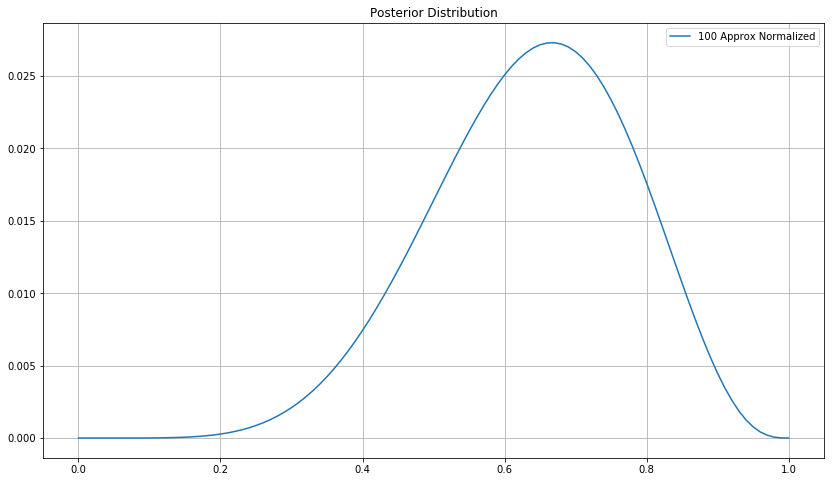

In [8]:
toss1 = globe_toss()
# Override the history so it match with book's example
toss1.toss_history = np.array(['W', 'W', 'W', 'W', 'W', 'L', 'L', 'L', 'W'])
toss1.plot_grid_approx(approx=100)
toss1.get_interval_balanced(.5)

`np.random.choice` digunakan untuk menarik sample dari distribusi posterior dalam python. Inputnya adalah array yang dari 0 sampai 1. Ada dua keyword argument yang dibutuhkan agar fungsi memiliki cara kerja yang sama dengan contoh R yang ada pada buku. Pertama adalah `size`, ini menentukan berapa sample yang akan ditarik dari distribusi posterior. Kedua adalah `p`, ini adalah input probabilitas yang akan mempengaruhi pemilihan sampel yang ditarik. Kardinalitas dari Input dan keyword argument `p` haruslah sama. Dalam class `globe_toss`, menarik sample dari posterior dapat dilakukan dengan memanggil method `get_posterior_sample`

Sample Example from Posterior [0.73 0.58 0.79 0.64 0.82 0.69 0.66 0.35 0.55 0.68]


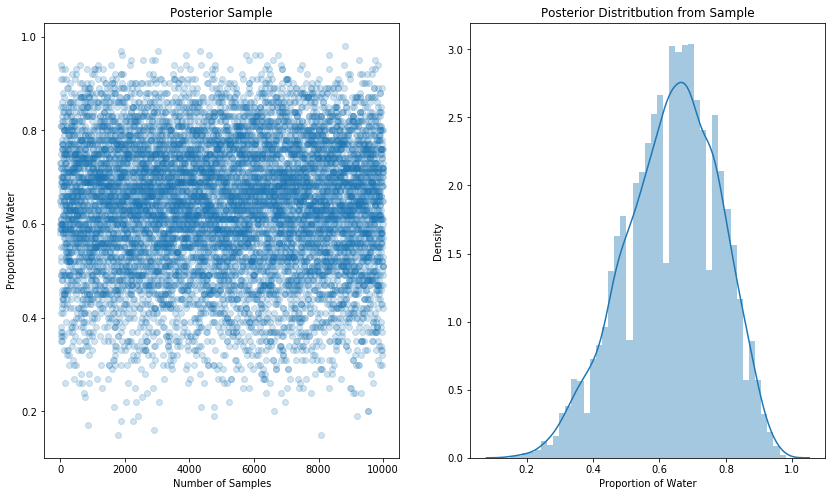

In [9]:
print("Sample Example from Posterior", toss1.get_posterior_sample(10))
toss1.plot_density_posterior_sample(10000)

Setelah mendapatkan sampeln dari distribusi posterior, dapat ditanyakan setidaknya tiga hal 

1. Interval dari batasan-batasan yang ada pada distribusi posterior
2. Interval dari probability mass
3. Point estimasi

Ditanyakan kemungkinan posterior dari air yang memiliki kemungkinan lebih besar dari 0.5. Ini dapat dilakukan dengan menjumlahkan nilai posterior yang bernilai $x$ kurang dari 0.5. Dalam python dan R dapat dilakukan dengan boolean masking. Boolean masking berkerja dengan menyeleksi array yang bernilai `True` dari masking. Dalam contoh dibawah, yang akan difilter adalah posterior dan `x_grid < 0.5` adalah maskingnya.

In [10]:
x_grid, posterior = toss1.grid_calculate_posterior()
print("SUM", sum(posterior[x_grid < 0.5]))

SUM 0.16375390354666275


Hal diatas juga dapat dicari menggunakan freqeusi dari sampel posterior. Semisal ditarik 10000 ribu sampel dari posterior, maka seharusnya jumlah sample yang bernilai kurang dari 0.5 akan sama dengan jumlah diatas setelah dinormalisasi, dalam python dapat dituliskan sebagai

In [11]:
sample_sizes = []
sample_freqs = []
for i in [1e1, 1e2, 1e3, 1e4, 1e5, 1e6]:
    i = int(i)
    samples = toss1.get_posterior_sample(i)
    print("Sample size {} freq {}".format(i, len(samples[samples < .5])/len(samples)))


Sample size 10 freq 0.2
Sample size 100 freq 0.24
Sample size 1000 freq 0.172
Sample size 10000 freq 0.1647
Sample size 100000 freq 0.16555
Sample size 1000000 freq 0.164325


apabila ingin dicari posterior dari dua batasan, masih dapat menggunakan fungsi yang sama. Sedikit berbeda dengan contoh pada R. Ini dikarenakan melakukan dua conditional.

In [12]:
samples = toss1.get_posterior_sample(int(1e4))
samples = samples[samples > .5]
samples = samples[samples < .75]
len(samples)/1e4

0.5871

Contoh diatas sudah diketahui batasanya seperti $p=0.5$. Hal yang selanjutnya dapat ditanyakan adalah pada nilai berapa letak quartil.

In [13]:
samples = toss1.get_posterior_sample(10000)
print("Quantile 80%", np.quantile(samples, .8))

Quantile 80% 0.76


In [14]:
print("Quantile 10%", np.quantile(samples, .1), "Quantile 10%", np.quantile(samples, .9))

Quantile 10% 0.45 Quantile 10% 0.81


Dalam buku, range quantile ini disebut sebagai percentile interval. Biasa digunakan untuk mengkomunikasikan bentuk distribusi selama distribusi tidak terlalu asymentris. Untuk kasus penyimpulan, percentile interval kurang membantu.

Quantile 25% 0.71 Quantile 75% 0.93 Distance 0.22000000000000008


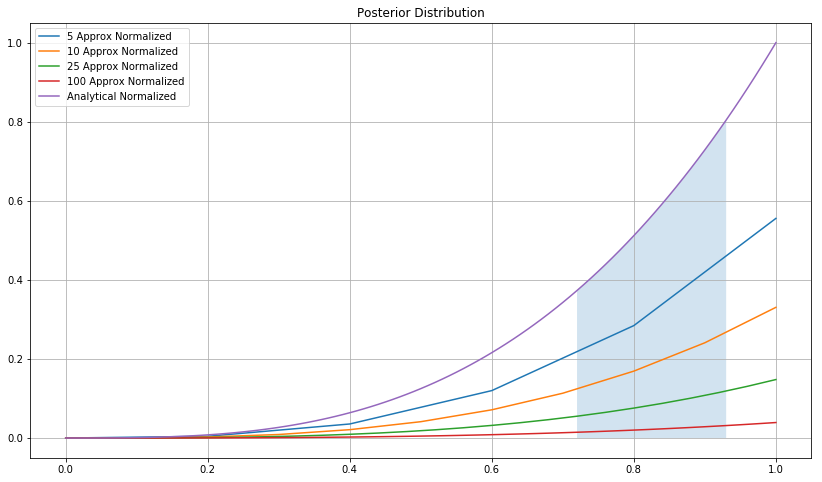

In [15]:
toss2 = globe_toss()
toss2.toss_history = np.array(['W', 'W', 'W'])
samples = toss2.get_posterior_sample(int(1e4))
q_low = np.quantile(samples, .25)
q_high = np.quantile(samples, .75)
print("Quantile 25%", q_low, "Quantile 75%", q_high, "Distance", q_high-q_low)
toss2.plot_grid_approx(interval=[.7171, .9393])

Pada grafik diatas, daerah yang diarsir memiliki batas dari 50%-- dari 0.25 sampai 0.75. Tetapi yang diarsir bukanlah bagian paling padat dari grafik tersbut (padat disini dapat disimpulkan dengan banyaknya sample yang menempati suatu probabilitas), bagian paling padatnya terntu saja ada pada dekat nilai 1. Interval lain yang digunakan untuk mencegah mengambil kesimpulan dari quantile ini adalah *Highest Posterior Density Interval* disingkan sebagai HDPI. HDPI dapat dihitung dengan cara memasukan probabilitas interval yang diinginkan dan akan dicari jarak minimum pada $x$ axis yang memiliki probabilitas interval yang diajukan. Untuk contoh ini digunakan analytic solution, tapi seharusnya dapat diterapkan ke solusi solusi lainya seperti grid, quadratic, dan monte carlo.

Distance 0.15000000000000002


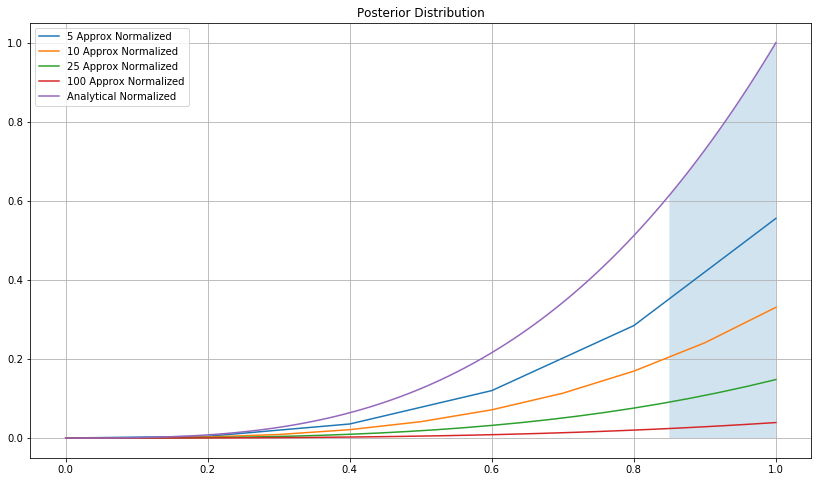

In [16]:
quantiles = toss2.get_hdpi(.5)
print("Distance", quantiles[1]-quantiles[0])
toss2.init_plot()
toss2.plot_grid_approx(interval=quantiles)

Bisa dilihat pada jarak antara interval HDIP lebih rendah dari jarak interval quantile. Meski lebih mewakili distribusi, HDPI memiliki beberapa kekurangan. HDPI menggunakan sumber daya komputasi lebih banyak dari pencarian quantile dikarenakan harus mencari nilai jarak paling kecil diantara semua kemungkinan quantile. Menurut buku, apabila distribusi tidak condong ke arah tertentu, quantile dan HDIP tidak begitu berbeda antara satu dengan yang lain.

Pertanyaan terakhir adalah estimasi point. Interval memili area tertentu yang akan ditinjau sedangkan point hanya spesifik satu titik saja. Dalam penarikan kesimpulan, setidaknya ada tiga poin penting yang dapat diambil dari sampel posterior. Pertama adalah MAP atau maximum a postriori, kedua adalah rerata, dan nilai tengah.

In [17]:
toss2.get_maximum_posteriori()

1.0

In [18]:
toss2.get_mean()

0.804179

In [19]:
toss2.get_median()

0.85

Dalam menentukan menggunakan yang mana, dapat dicari sebuah loss function, fungsi yang menjabarkan kerugian yang terjadi secara numerik pada setiap input yang memungkinkan.

In [20]:
x_grid, posterior = toss2.grid_calculate_posterior(20000)
np.sum(posterior * np.abs(0.5-x_grid))

0.3125187492187813

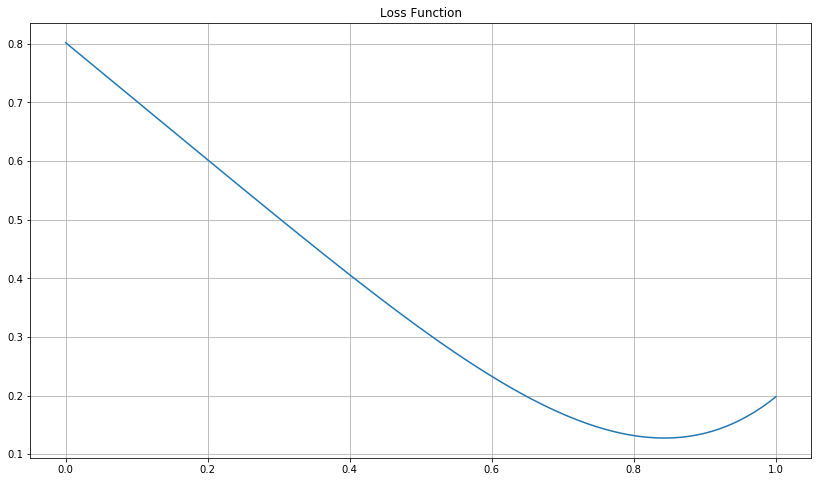

In [21]:
toss2.plot_loss_function()

In [22]:
x_loss_grid, loss_grid = toss2.get_loss_function()
print("Min Loss", x_loss_grid[np.where(loss_grid == np.min(loss_grid))[0][0]])

Min Loss 0.84


Sample posterior yang dihasilkan juga akan digunakan untuk observasi simulasi berdasarkan data yang sudah ada. Model yang dibangun akan mempermudah setidaknya pada empat bidang menurut buku
1. *Model design* -- Dalam Bayesian, selain posterior, prior juga dapat ditarik sampelnya. Ini penting untuk membandingkan kepercayaan sebelum dan setelah adanya data.
2. *Model checking* -- Setelah dihitung dengan data, apakah model posterior dapat memberikan kesimpulan dan behaviour yang diduga
3. *Software validation* -- Untuk menguji apakah model yang dibangun oleh perangkat adalah benar, ada baiknya diuji dengan model yang sudah menjadi standard untuk kalibrasi perangkat
4. *Research design* -- Penarikan sample ini juga dapat membuat peneliti menjelajahi kemungkinan-kemungkinan yang dihasilkan setelah tesedianya data.
5. *Forecasting* -- Model posterior juga dapat dijadikan dasar peramalan berdasarkan data yang tersedia serta kemungkinan-kemungkinan yang terjadi beserta probabilitasnya.

Kembali pada contoh pelemparan, semisal dilakukan pelemparan sebanyak dua kali maka akan ada tiga kemungkinan yang akan keluar adalah `L` `L`, `W` `W`, `L` `W`. Dapat dilakukan pencarian probabilitas terjadi pada masing-masing kemungkinan. Semisal diberikan probablilitas awal adalah 0.7 maka masing-masing kemungkinan adalah

In [23]:
toss3 = globe_toss()
possible_outcome = [
    ['L', 'L'],
    ['L', 'W'],
    ['W', 'W'],
]
for num, i in enumerate(possible_outcome):
    toss3.toss_history = np.array(i)
    toss3.update_possibility_water(.7)
    print(num, i, toss3.get_binom_toss())

0 ['L', 'L'] 0.09000000000000001
1 ['L', 'W'] 0.42
2 ['W', 'W'] 0.48999999999999994


berdasarkan perhitungan diatas dihasilkan posterior yang berbeda-beda. Kemungkinan bahwa dua kali pelemparan menghasilkan dua-duanya adalah `L` adalah 9% dan seterusnya. Apabila nilai `possibility_water` diganti, maka akan terganti juga kemungkinanya.

In [24]:
print("Binomial random pick", np.random.binomial(2, 0.7, size=10))

Binomial random pick [0 1 1 1 1 2 1 2 1 2]


In [25]:
samples = np.random.binomial(2, 0.7, size=10000)
count_samples_1 = len(samples[samples == 1])/len(samples)
count_samples_2 = len(samples[samples == 2])/len(samples)
count_samples_0 = len(samples[samples == 0])/len(samples)
print("Sample from 0 {} sample from 1 {} sample from 2 {}".format(count_samples_0, count_samples_1, count_samples_2))

Sample from 0 0.083 sample from 1 0.4195 sample from 2 0.4975


Diatas adalah dihitung untuk probablitas 0.7 dan dilakukan dua kali pelemparan. Apabila dilakukan sembilan kali pelemparan maka yang terjadi adalah distribusi diskrit yang dapat dipetakan sebagai berikut

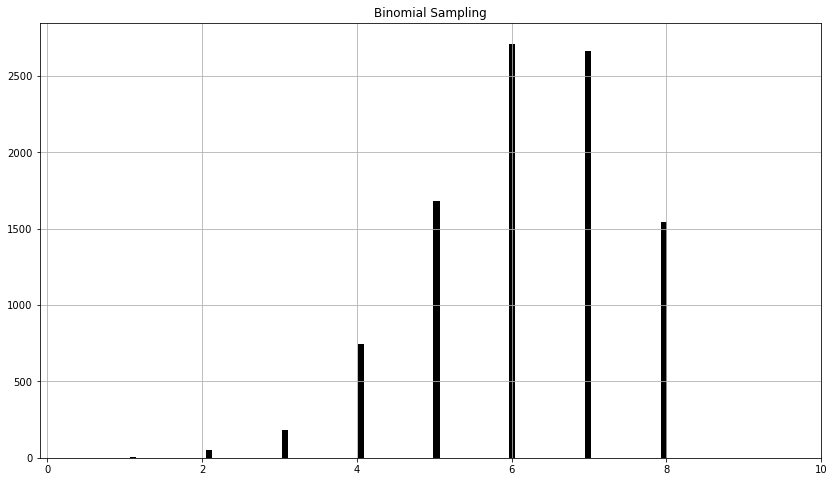

In [26]:
toss3.plot_binom_sampling(9, 10000)

In [27]:
toss4 = globe_toss()
toss4.toss(8)

array(['W', 'L', 'W', 'L', 'W', 'W', 'W', 'W'], dtype='<U32')

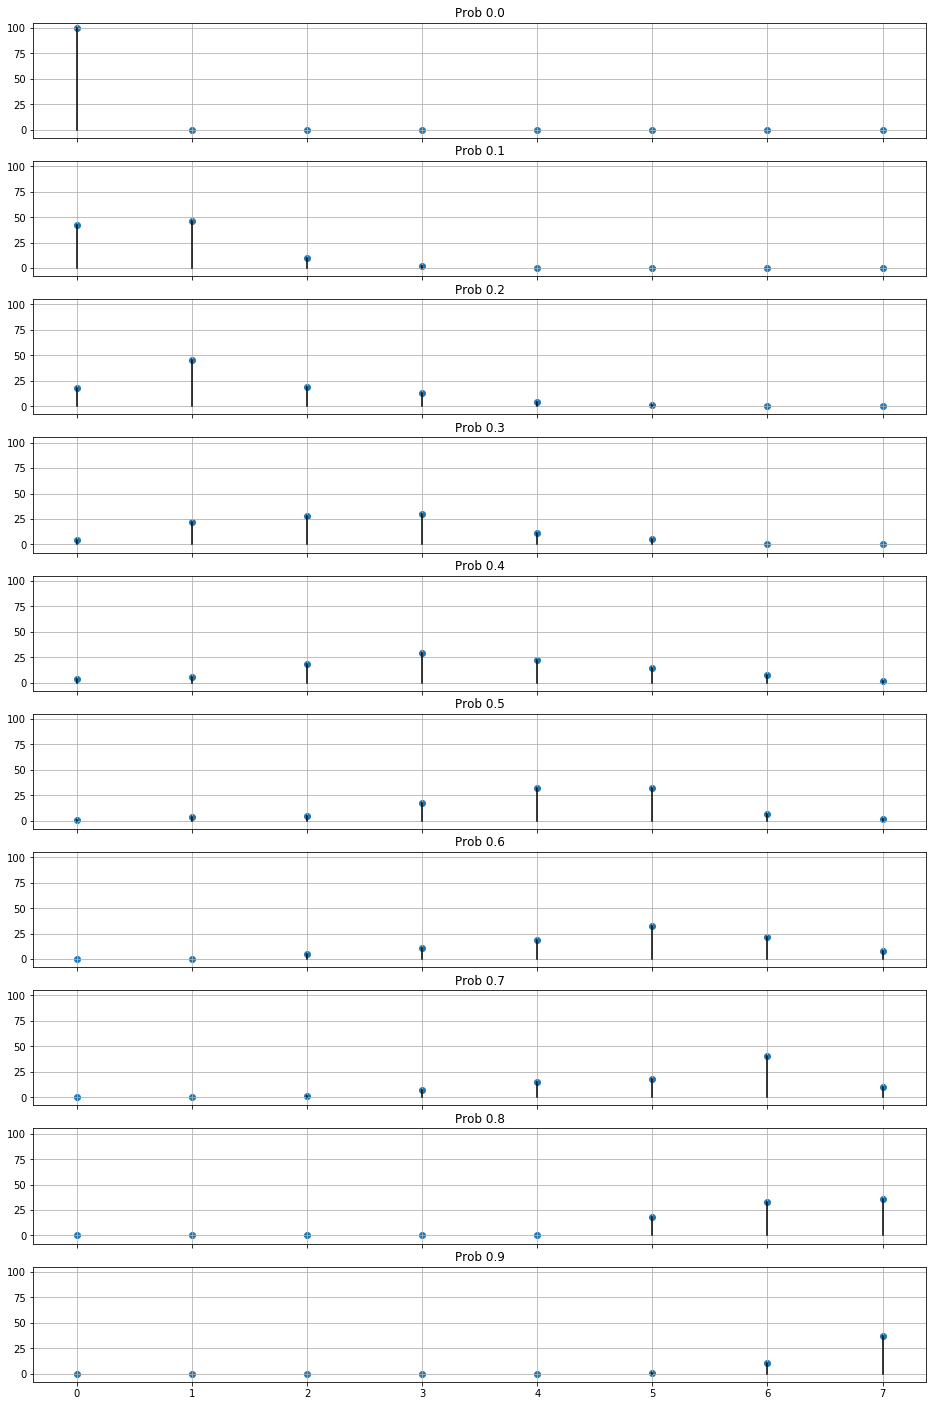

In [28]:
toss4.plot_multiple_binom_sampling(8, 100)

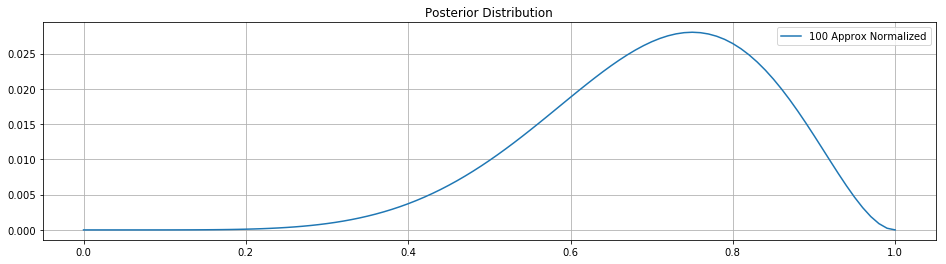

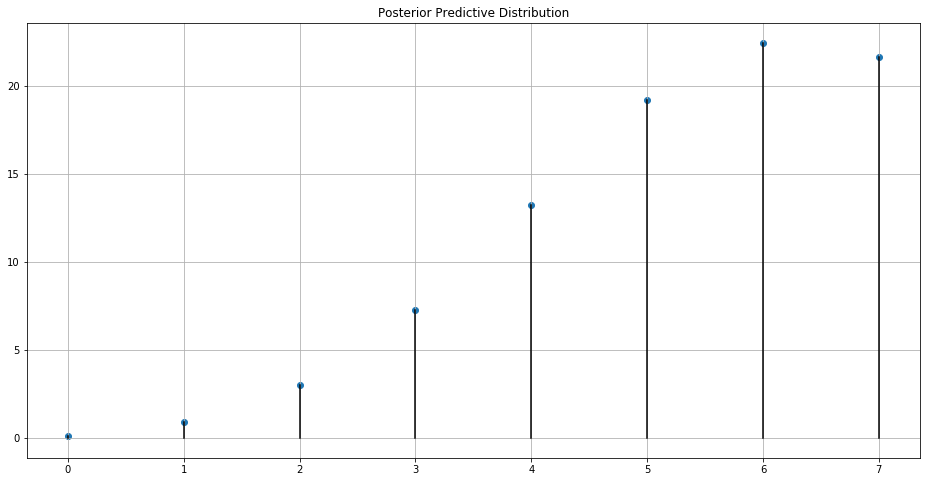

In [29]:
toss4.init_plot(dimension=[16, 4])
toss4.plot_grid_approx(approx=100)
toss4.plot_posterior_predictive_distribution(8, 100)

Posterior Predictive Distribution dihasilkan dari sampling prior pada masing masing kemungkinan, lalu semua kemungkinan tersebut dijumlahkan dan dikalikan dengan bobot yang didapat dari kemungkinan pada posterior. Hasilnya dapat dilihat pada grafik diatas. Pada grafik diatas, x axis menunjukan pelemparang yang menghasilkan air. Pada grafik posterior, menunjukan bahwa ada kecendrungan bahwa proportsi air adalah kecil. Dalam pelemparan ini akan berkonsekuensi pada rendahnya pelemparan yang menghasilkan banyak air.

# Practice

## Easy

In [30]:
np.random.seed(100)
discretization = 1000
toss_easy = globe_toss()
# Setting toss history so it has the same history as in book
toss_easy.toss_history = np.array(['W', 'W', 'W', 'W', 'W', 'L', 'L', 'L', 'W'])
x_grid, posterior_distribution = toss_easy.grid_calculate_posterior(discretization)
samples = toss_easy.get_posterior_sample(discretization)

3E1 Posterior dibawah nilai 0.2

Posterior Probability below 0.2 0.0008506560509113569


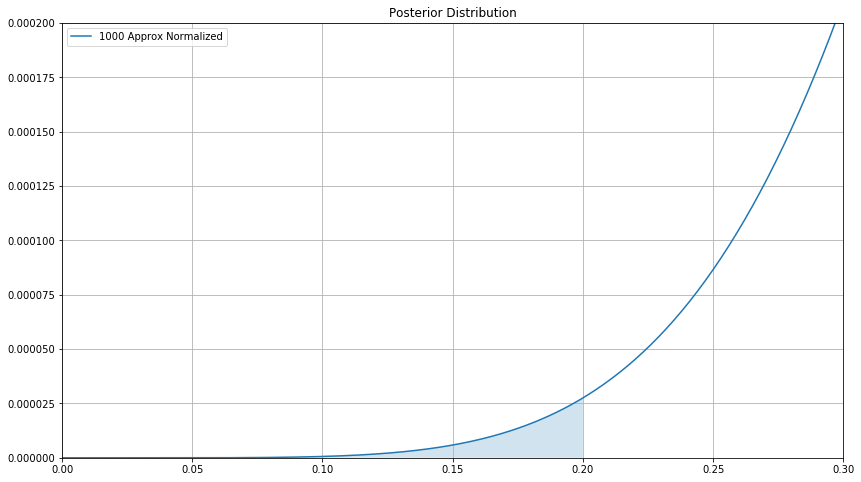

In [31]:
toss_easy.init_plot()
toss_easy.plot_grid_approx(interval=[0.0001, .2], xlim=[0, 0.3], ylim=[0,0.0002], approx=discretization)
print("Posterior Probability below 0.2", np.sum(posterior_distribution[x_grid < 0.2]))

3E2 Posterior diatas 0.8

Posterior Probability above 0.8 0.11999417877279497


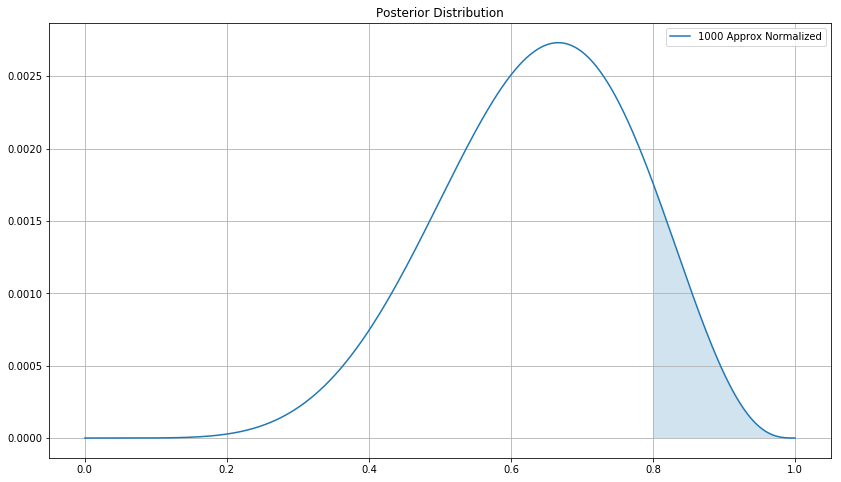

In [32]:
toss_easy.init_plot()
toss_easy.plot_grid_approx(interval=[0.8, 1], approx=discretization)
print("Posterior Probability above 0.8", np.sum(posterior_distribution[x_grid > 0.8]))

3E3 Posterior antara 0.2 dan 0.8

Posterior Probability above 0.2 and below 0.8 0.8773660323763062


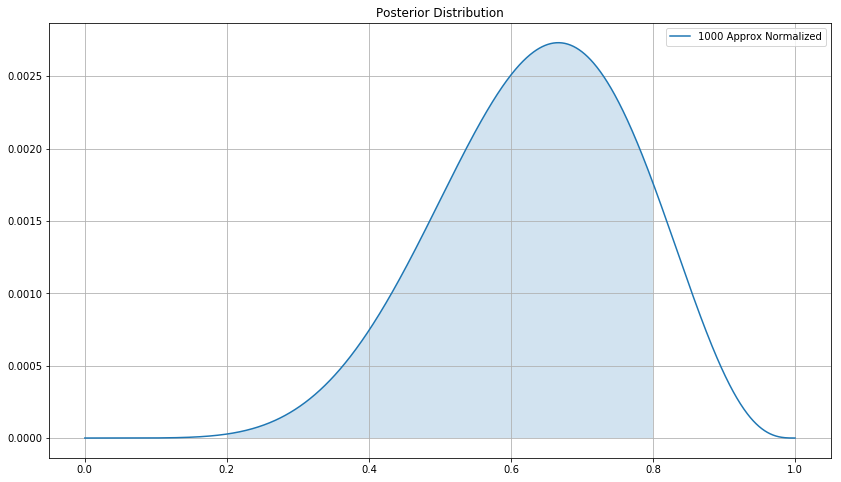

In [33]:
toss_easy.init_plot()
toss_easy.plot_grid_approx(interval=[0.2, 0.8], approx=discretization)
bitmask = np.bitwise_and(x_grid > 0.2, x_grid < 0.8)
print("Posterior Probability above 0.2 and below 0.8", np.sum(posterior_distribution[bitmask]))

3E4 Menggunakan sample, dicari quantile 20% terbawah

Quantile 20% 0.5


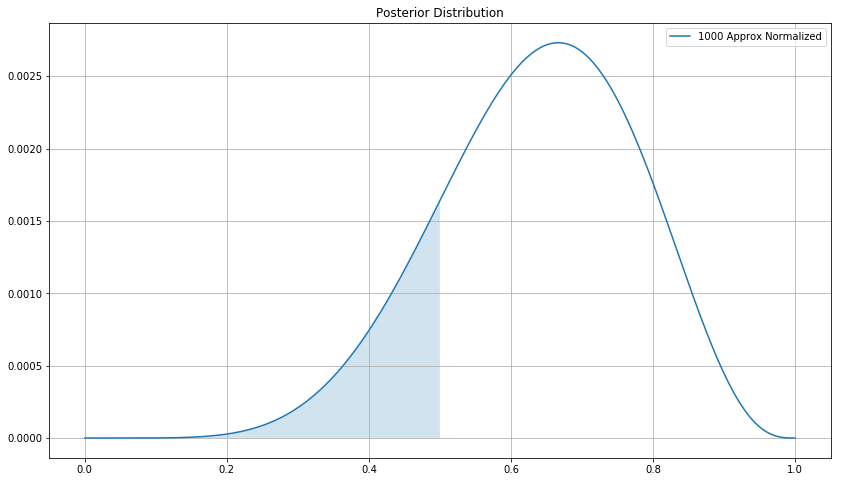

In [34]:
samples = toss_easy.get_posterior_sample(discretization + 1)
q_low = np.quantile(samples, .2)
print("Quantile 20%", q_low)
toss_easy.init_plot()
toss_easy.plot_grid_approx(interval=[0, q_low], approx=discretization)

3E5 Menggunakan sample, dicari quantile 80% teratas

Quantile 20% 0.75


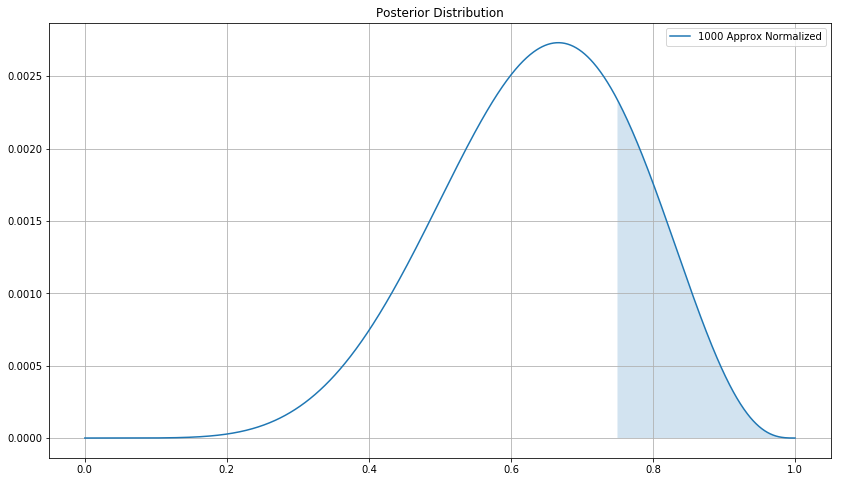

In [35]:
q_low = np.quantile(samples, .8)
print("Quantile 20%", q_low)
toss_easy.init_plot()
toss_easy.plot_grid_approx(interval=[q_low, 1], approx=discretization)

3E7 Dicari interval terkecil yang dengan yang mengandung 66% interval 

HDPI Interval 0.5 to 0.77


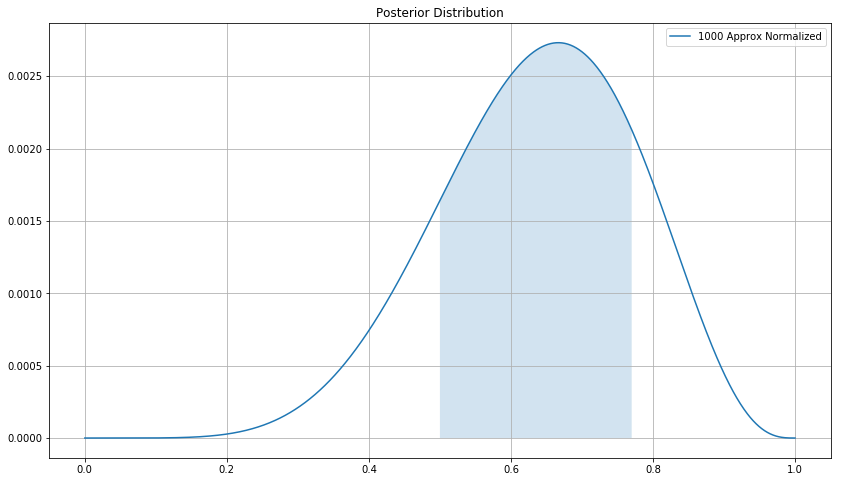

In [36]:
hdpi_interval = toss_easy.get_hdpi(.66)
print("HDPI Interval {} to {}".format(hdpi_interval[0], hdpi_interval[1]))
toss_easy.init_plot()
toss_easy.plot_grid_approx(interval=[hdpi_interval[0], hdpi_interval[1]], approx=discretization)

3E8 Dicari interval yang memiliki quantile .66 dengan syarat quantile bawah harus sama dengan quantile atas

In [37]:
same_interval = toss_easy.get_interval_balanced(.66)

Exception: Not found any interval that has same below and above interval

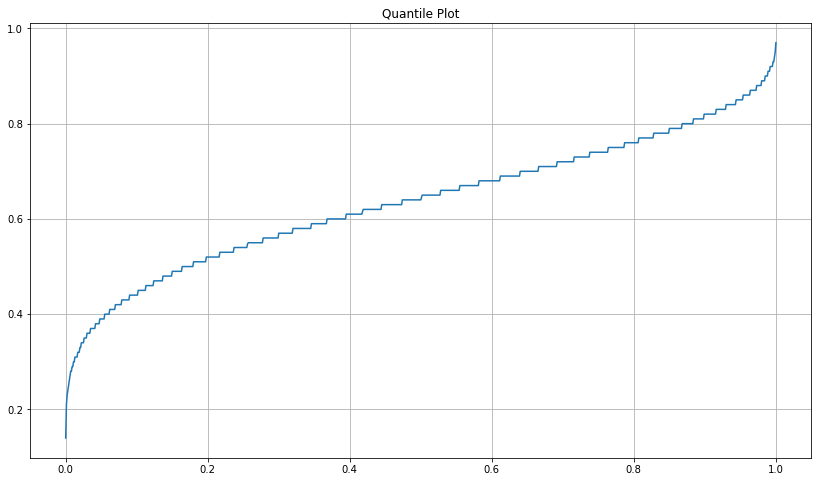

In [38]:
toss_easy.plot_quantile()

## Medium

In [39]:
toss_medium = globe_toss()
toss_medium.toss_history = np.array(['W'] * 8 + ['L'] * 7)

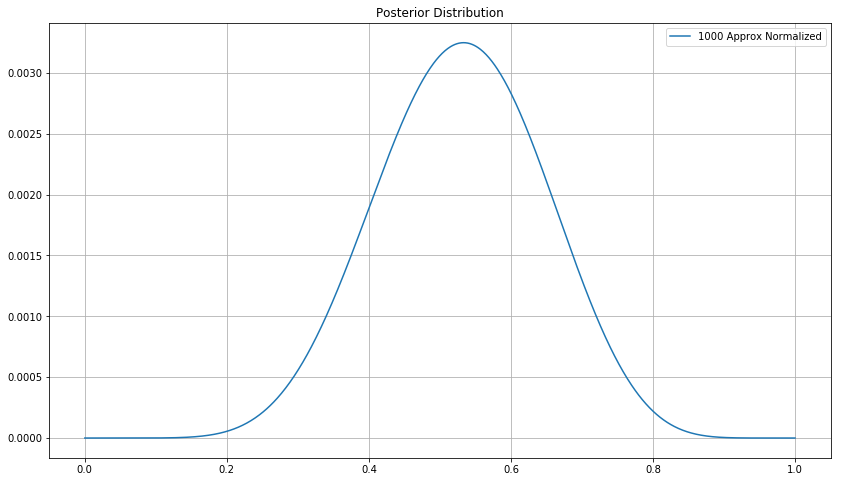

In [40]:
toss_medium.plot_grid_approx(approx=1000)

3M2 Diambil 10000 sampel dari posterior, pada interval berapa sampai berapa yang meghasilkan jarak interval minimal dengan mengandung 99% dari sampel

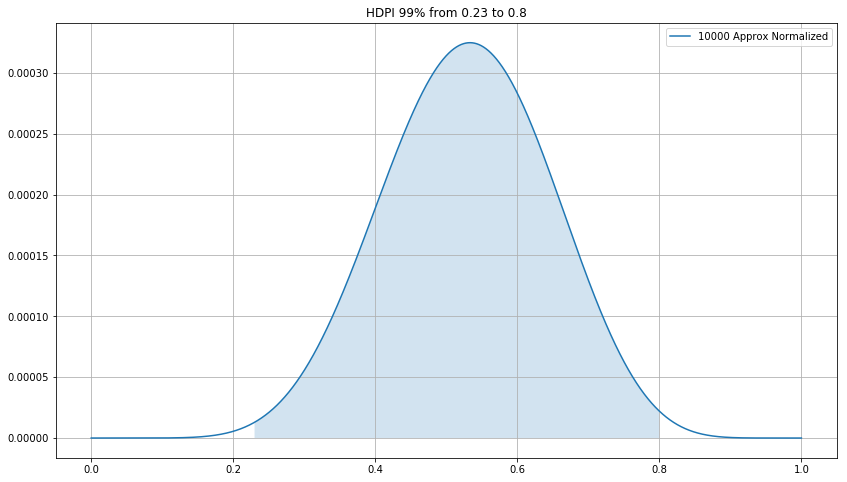

In [41]:
low_limit, up_limit = toss_medium.get_hdpi(.99, 10000)
toss_medium.init_plot("HDPI 99% from {} to {}".format(low_limit, up_limit))
toss_medium.plot_grid_approx(approx=10000, interval=[low_limit, up_limit])

3M3 Berdasarkan sampel yang sudah dibangun dari posterior ada berapa kemungkinan menghasilkan 8 air dari 15 kali pelemparan

8/15 Water Toss 7 0.13798602302286658


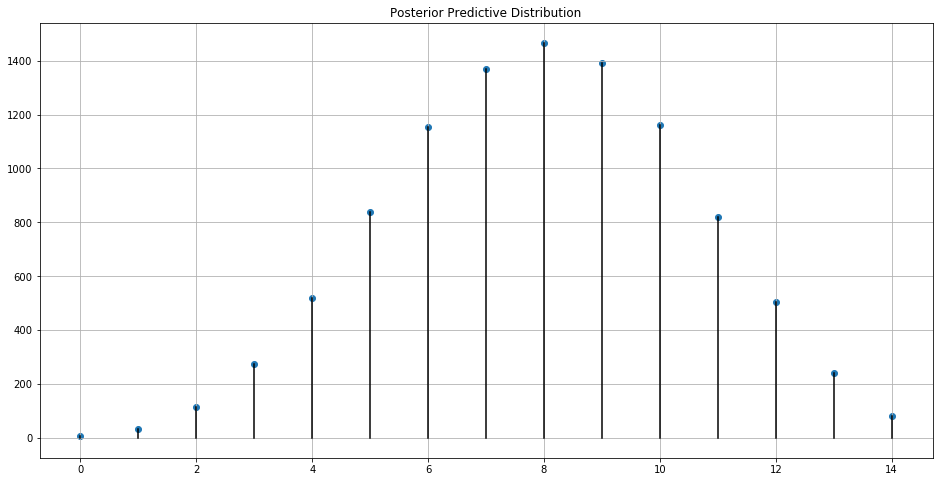

In [42]:
ppd = toss_medium.get_posterior_predictive_distribution(15, 10000)
toss_medium.plot_posterior_predictive_distribution(15, 10000)
print("8/15 Water Toss", ppd[0][7], ppd[1][7]/np.sum([ppd[1]]))

3M4 Menggunakan data sebelumnya, hitung kemungkinan keluar air sebanyak 6 kali dari 9 kali percobaan

6/9 Water Toss 5 0.21039062798674193


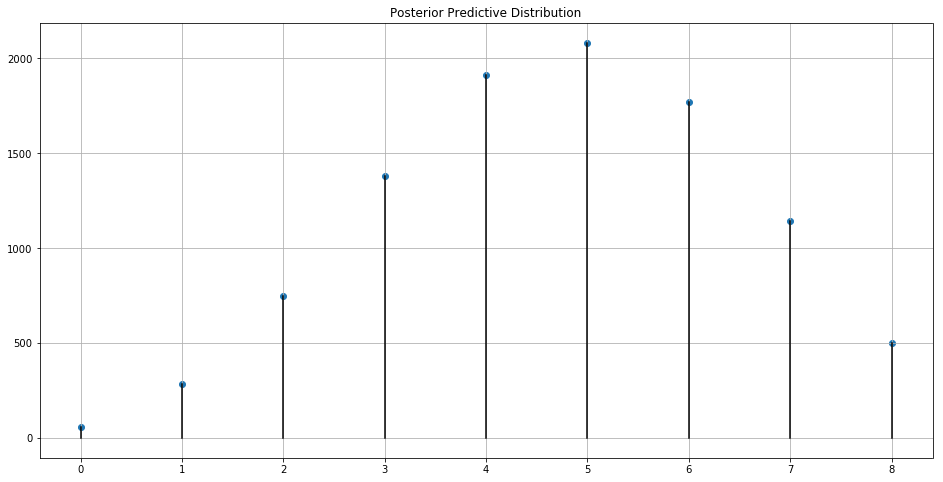

In [43]:
ppd = toss_medium.get_posterior_predictive_distribution(9, 10000)
toss_medium.plot_posterior_predictive_distribution(9, 10000)
print("6/9 Water Toss", ppd[0][5], ppd[1][5]/np.sum([ppd[1]]))

3M5 Digunakan step function untuk prior dengan informasi sisanya sama dengan pertanyaan sebelumnya ulangi pertanyaan dari satu sampai empat dan bandingkan hasilnya

In [44]:
def step_function(x):
    if x <= .5:
        return 0
    else:
        return 1
toss_medium.install_prior_function(step_function)

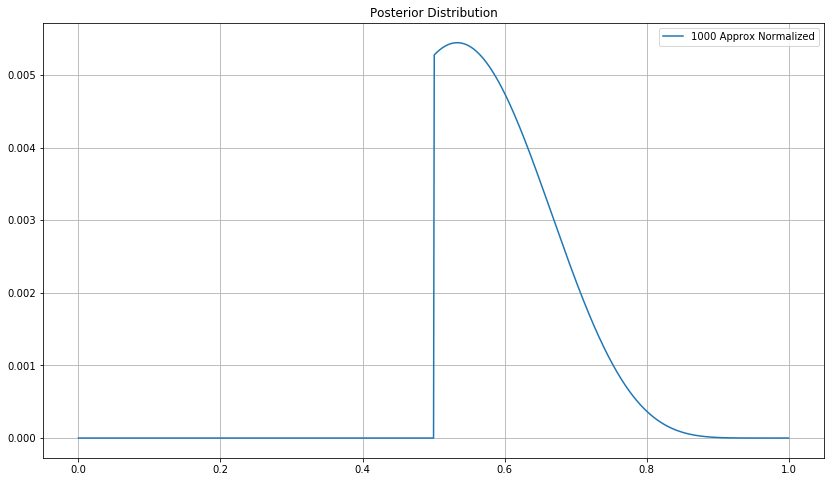

In [45]:
toss_medium.init_plot()
toss_medium.plot_grid_approx(approx=1000)

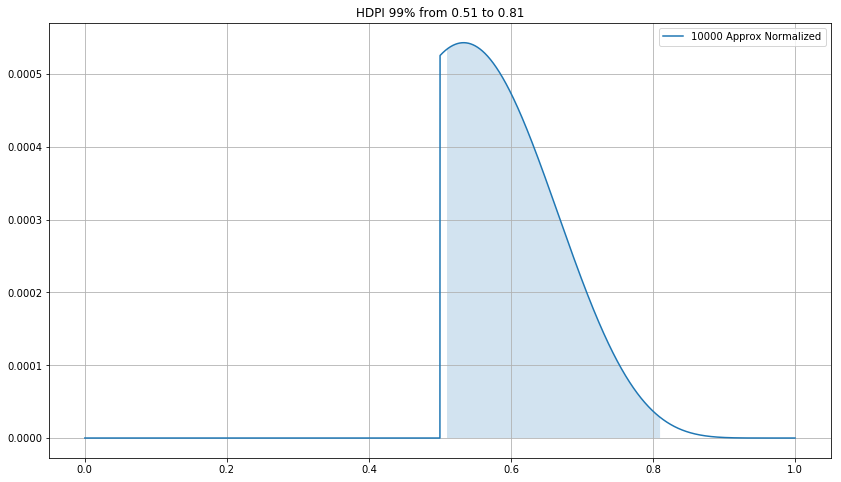

In [46]:
low_limit, up_limit = toss_medium.get_hdpi(.99, 10000)
toss_medium.init_plot("HDPI 99% from {} to {}".format(low_limit, up_limit))
toss_medium.plot_grid_approx(approx=10000, interval=[low_limit, up_limit])

8/15 Water Toss 7 0.11296160041752855


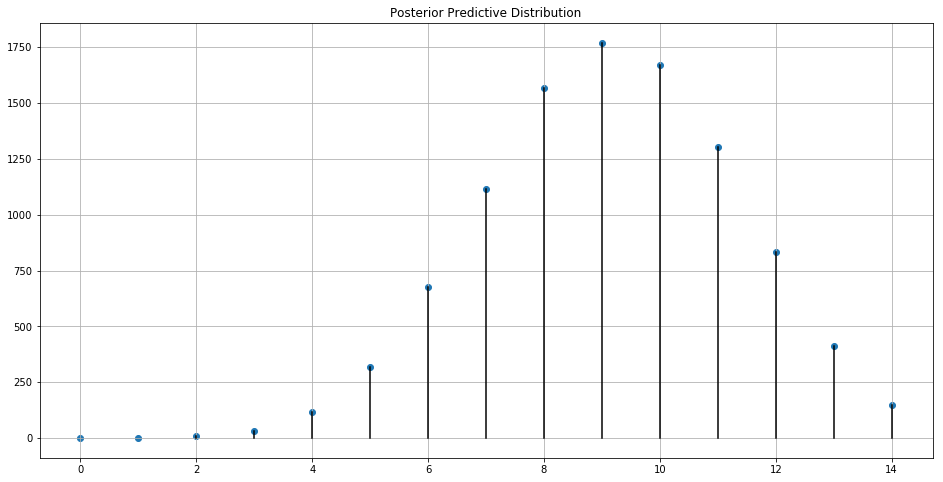

In [47]:
ppd = toss_medium.get_posterior_predictive_distribution(15, 10000)
toss_medium.plot_posterior_predictive_distribution(15, 10000)
print("8/15 Water Toss", ppd[0][7], ppd[1][7]/np.sum([ppd[1]]))

6/9 Water Toss 5 0.23042906395142126


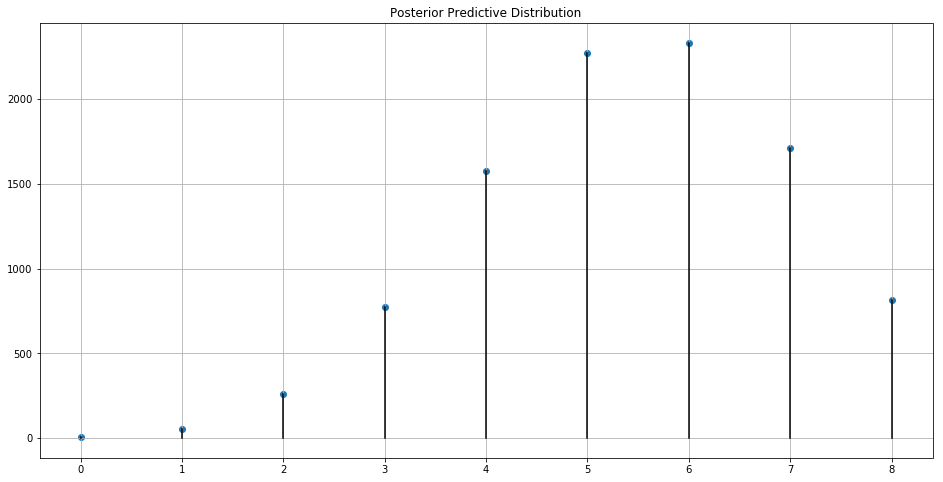

In [48]:
ppd = toss_medium.get_posterior_predictive_distribution(9, 10000)
toss_medium.plot_posterior_predictive_distribution(9, 10000)
print("6/9 Water Toss", ppd[0][5], ppd[1][5]/np.sum([ppd[1]]))

Apabila dibandingkan dengan flat prior, step function prior dapat mengarahkan kecendrungan ke satu sisi tertentu yang dalam dalam kasus ini adalah nilai diatas 0.5. Ini menandakan sample yang dihasilkan prior akan memiliki kecendrungan ke sisi tertentu juga. Meski secara prior ada perubahan ekstrim, hasil dari posterior predictive distribution tidak menunjukan perbedaan yang signifikan. Saat menggunakan flat prior hasil air 6 kali dari 9 berada pada $0.2097$ sedangkan untuk step function prior, hasil air 6 kali dari 9 berada pada $0.2317$

3M6 Berapa kali pelemparan yang menghasilkan 99 persen interval ada pada jarak 0.05?

In [49]:
interval_length = 1
toss_medium.clear_prior_function()
toss_medium.toss_history = np.array(['W'] * 8 + ['L'] * 7)
count_break = 0
while interval_length > .05:
    toss_medium.toss(10)
    low_limit, up_limit = toss_medium.get_hdpi(.99)
    interval_length = up_limit - low_limit
    count_break += 1
    if count_break % 20 == 0:
        print("COUNT {} DISTANCE {}".format(count_break, interval_length))
print("In order to get .05 distance that occupy 99% need {} toss".format(len(toss_medium.toss_history)))

COUNT 20 DISTANCE 0.17000000000000004
COUNT 40 DISTANCE 0.12
COUNT 60 DISTANCE 0.09999999999999998
COUNT 80 DISTANCE 0.07999999999999996
COUNT 100 DISTANCE 0.06999999999999995
COUNT 120 DISTANCE 0.06999999999999995
COUNT 140 DISTANCE 0.05999999999999994
COUNT 160 DISTANCE 0.05999999999999994
In order to get .05 distance that occupy 99% need 1755 toss


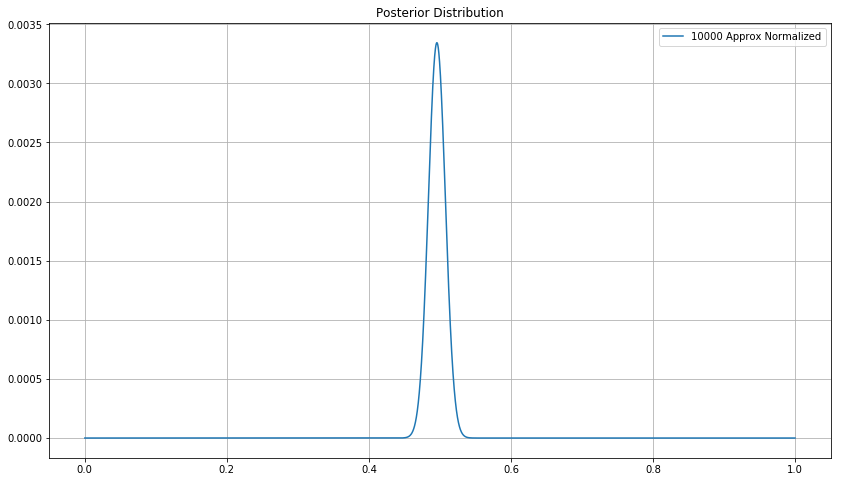

In [50]:
toss_medium.init_plot()
toss_medium.plot_grid_approx(approx=10000)

## Hard

In [68]:
first_birth = [1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,
0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,
1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,
1,0,1,1,1,0,1,1,1,1]

second_birth = [0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0]

sum(first_birth) + sum(second_birth)

111

Dengan asumsi bahwa kelahiran pertama tidak memiliki pengaruh terhadapt kelahiran kedua, data diatas dapat digabungkan. Agar dapat menggunakan kembali class yang sudah dibangun, maka laki-laki dapat diasumsikan sebagai air dan perempuan sebagai tanah dalam kasus pelemparan.

3H1

Number of Water 111 from 200


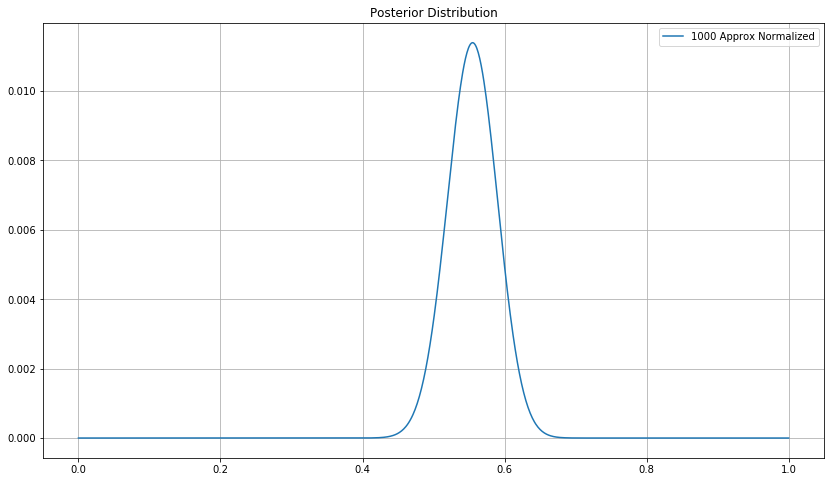

In [69]:
total_birth_converted = np.array(['W' if i == 1 else 'L' for i in first_birth + second_birth])
toss_hard = globe_toss()
toss_hard.toss_history = total_birth_converted
toss_hard.plot_grid_approx(approx=1000)
print("Number of Water", toss_hard.get_water_total(), "from", len(total_birth_converted))

Nilai yang memaksimalkan kemungkinan kelahiran laki-laki adalah jumlah data laki-laki yang lahir.

Number of Water 51 from 100


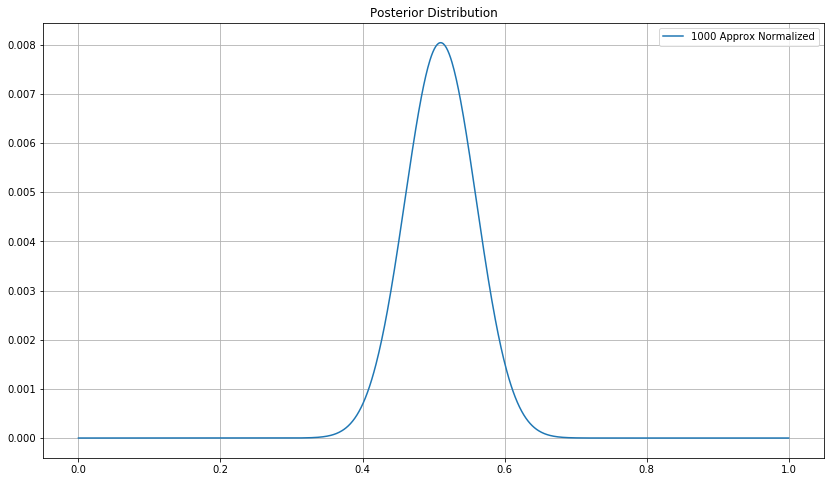

In [70]:
first_birth_converted = np.array(['W' if i == 1 else 'L' for i in first_birth])
toss_hard_first = globe_toss()
toss_hard_first.toss_history = first_birth_converted
toss_hard_first.plot_grid_approx(approx=1000)
print("Number of Water", toss_hard_first.get_water_total(), "from", len(first_birth_converted))

Number of Water 60 from 100


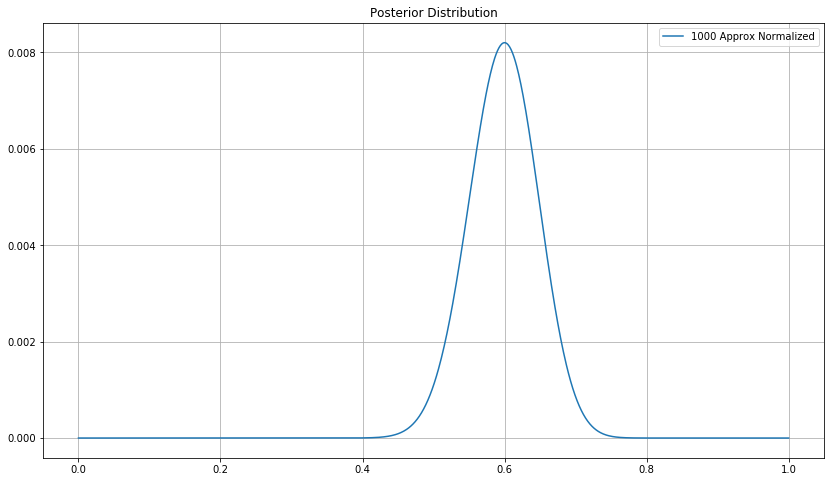

In [71]:
second_birth_converted = np.array(['W' if i == 1 else 'L' for i in second_birth])
toss_hard_second = globe_toss()
toss_hard_second.toss_history = second_birth_converted
toss_hard_second.plot_grid_approx(approx=1000)
print("Number of Water", toss_hard_second.get_water_total(), "from", len(second_birth_converted))

3H2 Diambil 10000 sampel dari posterior yang sudah dihasilkan. Posterior yang digunakan adalah yang kombinasi antara kelahiran pertama dan kelahiran kedua. Dicari HDPI dengan 50%, 89% dan 97%

In [72]:
interval = toss_hard.get_hdpi(.5, 10000)
print("HDPI interval for 50% {} from {}".format(interval[0], interval[1]))

interval = toss_hard.get_hdpi(.89, 10000)
print("HDPI interval for 89% {} from {}".format(interval[0], interval[1]))

interval = toss_hard.get_hdpi(.97, 10000)
print("HDPI interval for 97% {} from {}".format(interval[0], interval[1]))

HDPI interval for 50% 0.54 from 0.58
HDPI interval for 89% 0.5 from 0.6099999999999999
HDPI interval for 97% 0.47000000000000003 from 0.6199999999999999


3H3 Menggunakan distribusi binomial, simulasikan 200 kelahiran 10.000 kali. 

Sample that generate 111 boys occurs 173 times


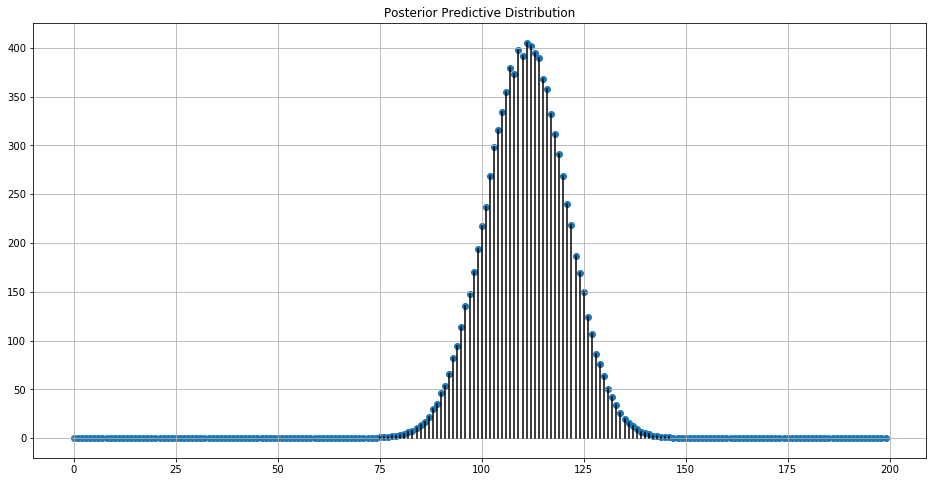

In [73]:
x_grid, binomial_samples = toss_hard.get_binomial_sampling(200, 10000)
toss_hard.plot_posterior_predictive_distribution(200, 10000)
print("Sample that generate 111 boys occurs {} times".format(len(binomial_samples[111])))

Sample that generate 111 boys occurs 160 times


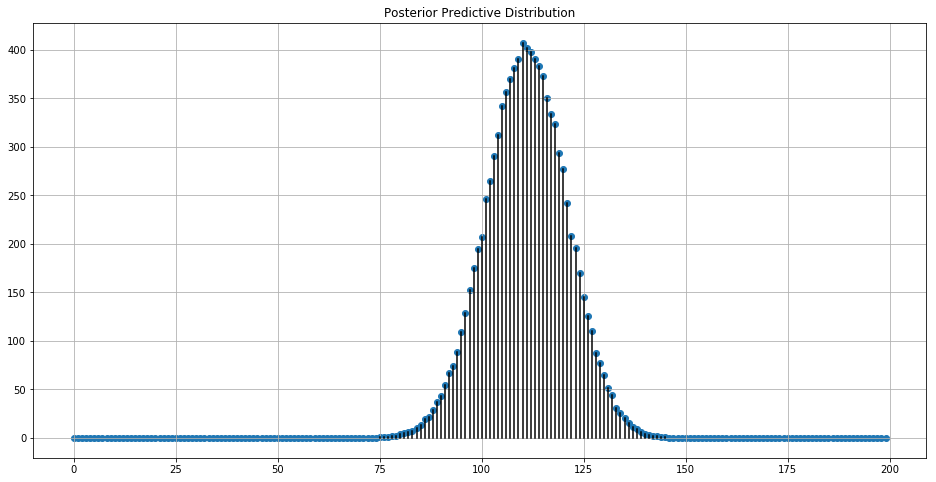

In [74]:
x_grid, binomial_samples = toss_hard_first.get_binomial_sampling(200, 10000)
toss_hard.plot_posterior_predictive_distribution(200, 10000)
print("Sample that generate 111 boys occurs {} times".format(len(binomial_samples[111])))

3H4 Diambil perhitungan kelahiran laki-laki dari kombinasi distribusi kelahiran pertama dan kedua. Dari 10000 pengambilan sample dan dalam setiap pengambilan dilakukan 200 kelahiran, munculnya 111 kelahiran laki-laki terjadi 139 kali dari 10000 sampel. Saat menggunakan distribusi hanya kelahiran pertama ditemukan 111 kelahiran laki-laki terjadi 170 dari 10000 sampel. Dari dua paragraf diatas dapat diambil kesimpulan bahwa distribusi kelahiran pertama lebih mendekati data yang tersedia.

3H5 ditarik sample dari distribusi kelahiran pertama dan yang kedua lalu dibandingkan relasi antara keduanya. Pada satu penarikan diambil 200 sample dari masing masing distribusi. Hal ini dilakukan sebanyak 10000 kali. Pertama dicari kelahiran yang pertama adalah laki-laki dan yang kedua adalah perempuan.

Menurut pemahaman saya, yang harus dilakukan adalah melakukan klasifikasi ulang. Klasifikasi pertama adalah klasifikasi untuk membedakan kelahiran pertama laki-laki yang diikuti lahiran kedua perempuan. Klasifikasi kedua adalah sebaliknya. Nilai yang menjadi klasifikasi akan menjadi `W` dan yang tidak masuk akan menjadi `L`. 

In [79]:
samples_first = toss_hard_first.get_binomial_sampling_random(200,10000, None)
samples_second = toss_hard_second.get_binomial_sampling_random(200,10000, None)

In [83]:
new_history = []
for i in range(len(first_birth)):
    if first_birth[i] == 1 and second_birth[i] == 0:
        new_history.append('W')
    else:
        new_history.append('L')

toss_hard_combination_1 = globe_toss()
toss_hard_combination_1.toss_history = np.array(new_history)

new_history = []
for i in range(len(first_birth)):
    if first_birth[i] == 0 and second_birth[i] == 1:
        new_history.append('W')
    else:
        new_history.append('L')

toss_hard_combination_2 = globe_toss()
toss_hard_combination_2.toss_history = np.array(new_history)

Boy then girl in actual data 30


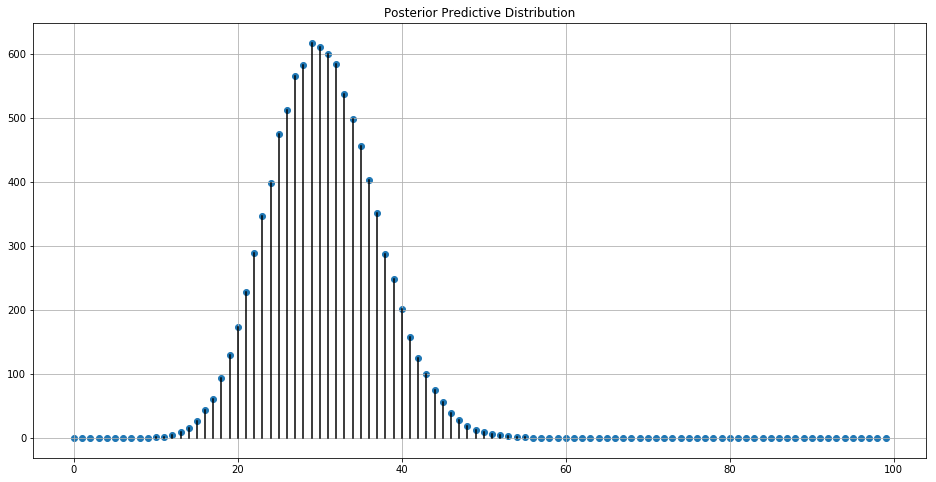

In [92]:
toss_hard_combination_1.plot_posterior_predictive_distribution(100, 10000)
print("Boy then girl in actual data", toss_hard_combination_1.get_water_total())

Girl then boy in actual data 39


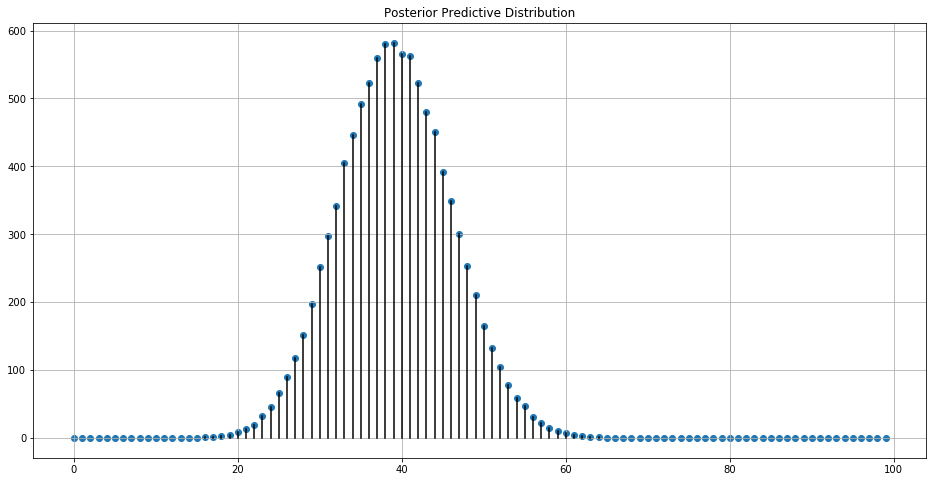

In [93]:
toss_hard_combination_2.plot_posterior_predictive_distribution(100, 10000)
print("Girl then boy in actual data", toss_hard_combination_2.get_water_total())

Pada distribusi kelahiran laki-laki lalu perempuan ditemukan bahwa pada data yang disediakan, ditemukan kombinasi sebanyak 30 dari 100 kelahiran memenuhi klasifikasi. Ini sesuai dengan distribusi prediktif posterior yang memiliki puncak pada 30an. Hal yang sama terjadi juga ada pada klasifikasi kelahiran perempuan diikuti dengan laku-laki.
> Terus ini nyari kolerasinya gimana kalo sudah dapat seperti ini?